# Usage of the Event Detector by Jin et al.

# Load the required packages

In [18]:
# Import public packages
import sys
import os
from pathlib import Path
import ipdb
from matplotlib import pyplot as plt
import glob
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from io import StringIO

# Add src to the path for import
project_dir = Path(os.getcwd()).resolve().parents[0]
module_path = os.path.abspath(os.path.join(project_dir))  
if module_path not in sys.path:
    sys.path.append(module_path)

# Import private source code
from Event_Detectors import EventDet_Jin

# Activate Autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set all global Parameters for the BLUED Dataset

In [19]:
# Hardcoded Hyperparameters
DATASET_LOCATION_BLUED = os.path.join("./Test_Data/") #Path to Test Data
DATASET = "blued_events" #name of the dataset (used to load the file later with my Utility class)
CURRENT_COLUMN = "Current B" # Dataset has two phases: phase A and B. They can be treated independently. We load only Phase B.
NETWORK_FREQUENCY_BLUED = 60 # Base electrical network frequency of the region where the dataset was recorded
SAMPLES_PER_SECOND_BLUED = NETWORK_FREQUENCY_BLUED # We compute two features (data points) per second.
SAMPLERATE_BLUED = 12000 # Sampling Rate the raw BLUED Dataset was recorded with 

# Compute the period size of the BLUED dataset: i.e. number of raw data points per period
BLUED_period = int(SAMPLERATE_BLUED / NETWORK_FREQUENCY_BLUED) 

# Load and display the BLUED Test File

In [20]:
def load_file_BLUED(file_path, phase="b"):
    """
    Function to load the BLUED test data.
     Args:
            file_path (Path): full path to the test file
            phase (string): either "all", "b" or "a". Returns only the requested phase of the dataset.

    Returns:
            data_df (pandas DataFrame): original columns if phase=="all" else colums are just "Current" and "Voltage" --> already for the matching phase! (* - 1 done for B)
            file_info (dict): dictionary with information about the file that was loaded. Parsed from the filename
            and the metadata included in the file.
    """
    with open(file_path, 'r') as f:

            data_txt = f.read()

            lines = data_txt.splitlines()

            data_txt = data_txt.split("***End_of_Header***")
            reference_time = data_txt[0].split("Date,")[1][:11].replace("\n","") +"-"+ data_txt[0].split("Time,")[1][:15]
            reference_time = datetime.strptime(reference_time, '%Y/%m/%d-%H:%M:%S.%f')


            data_time_str = data_txt[1].split("Time,")[1]
            data_time_str = data_time_str.split(',')

            data_day_str = data_txt[1].split("Date,")[1]
            data_day_str = data_day_str.split(',')

            day_str = data_day_str[0]  # just the first on is enoguh
            time_str = data_time_str[0][:15]  # same for time
            date = day_str + "-" + time_str
            start_date_time = datetime.strptime(date, '%Y/%m/%d-%H:%M:%S.%f')

            filename = Path(file_path).name  # get the file name

            samples = data_txt[1].split("Samples,")[1].split(",")[0:3][0]
            samples = int(samples)

            values_str = data_txt[-1]
            values_str = values_str[values_str.index("X_Value"):]

            measurement_steps = data_txt[1].split("Delta_X")[1].split(",")[0:3]
            measurement_steps = [float(x) for x in measurement_steps if x != ""]
            measurement_steps = measurement_steps[0]

            data_df = pd.read_csv(StringIO(values_str), usecols=["X_Value", "Current A", "Current B", "VoltageA"])

            data_df.dropna(inplace=True,how="any")
           
            file_duration = data_df.tail(1)["X_Value"].values[0]
            file_duration = float(file_duration)

            file_duration = timedelta(seconds=file_duration)
            end_date_time = reference_time + file_duration

            file_duration = end_date_time - start_date_time

            # Convert totimestamps
            data_df["TimeStamp"] = data_df["X_Value"].apply(lambda x: timedelta(seconds=x) + reference_time)
            data_df.drop(columns=["X_Value"],inplace=True)
            data_df.set_index("TimeStamp",inplace=True)

            file_info = {"Filepath": file_path, "Filename": filename, "samples": samples,
                         "file_start": start_date_time, "file_duration": file_duration, "file_end": end_date_time,
                         "measurement_steps": measurement_steps,"reference_time":reference_time}

            if phase.lower() != "all":
                if phase.lower() == "a":
                    data_df["Current"] = data_df["Current A"]
                    data_df["Voltage"] = data_df["VoltageA"]
                elif phase.lower() == "b":
                    data_df["Current"] = data_df["Current B"]
                    data_df["Voltage"] = data_df["VoltageA"].values * -1
                else:
                    raise ValueError("The phase provided does not exist")

                data_df.drop(columns=['Current A', 'Current B',"VoltageA"],inplace=True)

    return data_df, file_info

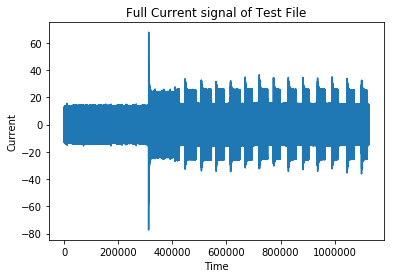

In [48]:
# Get the Test File
test_file = glob.glob(os.path.join(DATASET_LOCATION_BLUED, "*.txt"))[0] #get the full path of the test file

# Load the Data from the test File
data,file_info = load_file_BLUED(test_file)

current = data["Current"].values
voltage = data["Voltage"].values

# Plot the data from the test File
plt.title("Full Current signal of Test File")
plt.ylabel("Current")
plt.xlabel("Time")
plt.plot(current)
plt.show()


# Run the Event Detection on the Test Data

+++++++++++++++++++++++++++++++++++


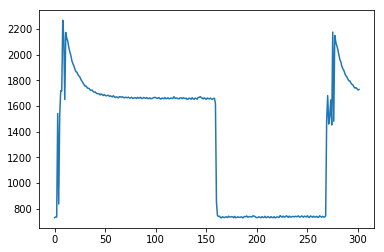

Event Detected at [datetime.datetime(2011, 10, 23, 20, 35, 48, 340166)]
+++++++++++++++++++++++++++++++++++


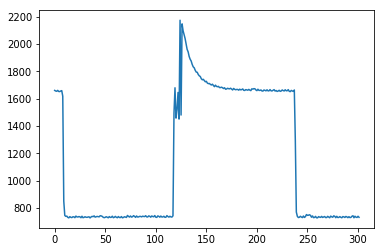

Event Detected at [datetime.datetime(2011, 10, 23, 20, 35, 50, 840166)]
+++++++++++++++++++++++++++++++++++


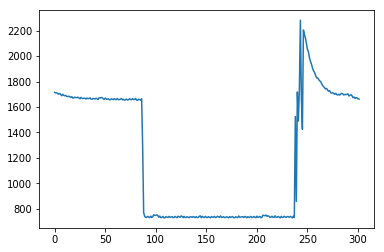

Event Detected at [datetime.datetime(2011, 10, 23, 20, 35, 53, 340167)]
+++++++++++++++++++++++++++++++++++


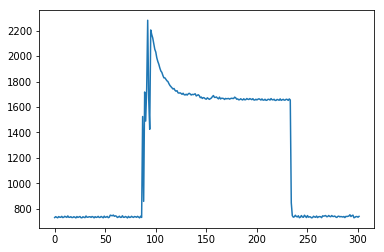

Event Detected at [datetime.datetime(2011, 10, 23, 20, 35, 55, 940167)]
+++++++++++++++++++++++++++++++++++


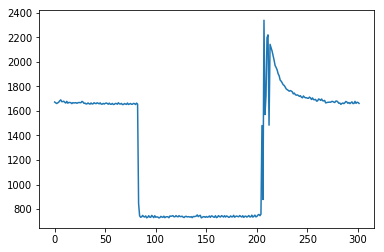

Event Detected at [datetime.datetime(2011, 10, 23, 20, 35, 58, 390167)]
+++++++++++++++++++++++++++++++++++


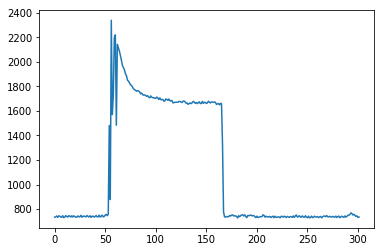

Event Detected at [datetime.datetime(2011, 10, 23, 20, 36, 0, 890168)]
+++++++++++++++++++++++++++++++++++


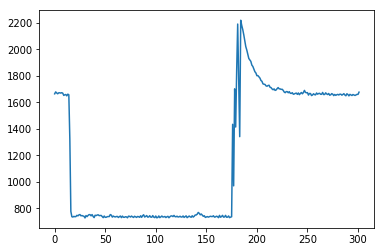

Event Detected at [datetime.datetime(2011, 10, 23, 20, 36, 3, 440168)]
+++++++++++++++++++++++++++++++++++


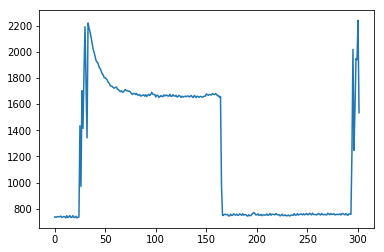

Event Detected at [datetime.datetime(2011, 10, 23, 20, 36, 5, 940168)]
+++++++++++++++++++++++++++++++++++


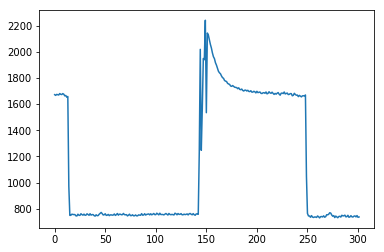

Event Detected at [datetime.datetime(2011, 10, 23, 20, 36, 8, 840169)]
+++++++++++++++++++++++++++++++++++


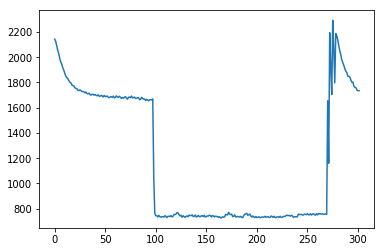

Event Detected at [datetime.datetime(2011, 10, 23, 20, 36, 10, 973502)]
+++++++++++++++++++++++++++++++++++


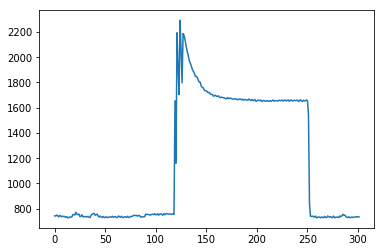

Event Detected at [datetime.datetime(2011, 10, 23, 20, 36, 13, 490169)]
+++++++++++++++++++++++++++++++++++


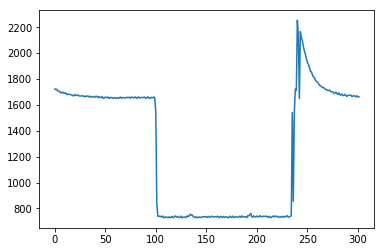

Event Detected at [datetime.datetime(2011, 10, 23, 20, 36, 15, 990170)]
+++++++++++++++++++++++++++++++++++


In [50]:
# Step 1: Initialize  the Event Detector
Jin = EventDet_Jin() 

# Step 2: Fit the event detector on some portions of the data
voltage_training = voltage[:int(BLUED_period*60*30)] # just use 30 seconds for training here
current_training = current[:int(BLUED_period*60*30)]
active_power = Jin.compute_input_signal(voltage=voltage_training, current=current_training, period_length=BLUED_period)  
Jin = Jin.fit(x=active_power, sampling_rate=SAMPLERATE_BLUED) # Call the fit() method to further initialize the algorithm (required by the sklearn API)

# From the fit we get the required window size, the Jin algorithm estiamtes it based on the training data
window_size_samples = Jin.n_mean_  # the precomputed mean window size
window_size_seconds = window_size_samples / SAMPLERATE_BLUED #window_size in seconds
    
# Remove the training data from the overall data
voltage = voltage[int(BLUED_period*60*30):]
current = current[int(BLUED_period*60*30):]

samples_remaining = len(current) # number of samples that we have not predicted yet
window_start = 0 # offset of the next window
window_start_timestamp = file_info["file_start"] + timedelta(seconds=30) #first 30 seconds used for training
previous_window = None # Jin needs to windows, i.e. before and after event
while samples_remaining >= window_size_samples: #while we still have samples to "stream" do the following
    
    window_stop = int(window_start + window_size_samples) # compute end index of the new window
    window_end_timestamp = window_start_timestamp + timedelta(seconds=window_size_seconds)
    
    # Get the voltage and current windows
    voltage_window = voltage[window_start:window_stop]
    current_window = current[window_start:window_stop]

    # Step 3: Use the feature computation function of the algorithm to compute the input features
    active_power = Jin.compute_input_signal(voltage=voltage_window, current=current_window, period_length=BLUED_period)     
    
    
    if previous_window is not None:
        X = np.stack([previous_window,active_power])
        
        plt.plot(X.flatten())
        plt.show()
        # Step 4: Run the prediciton on the features
        events = Jin.predict(X, window_start_timestamp, window_end_timestamp ) 

        if events is not None: # if an event is returned

            print("Event Detected at " + str(events))
        

    # We start at the end of the previous window
    window_start = int(window_stop)
    window_start_timestamp = window_end_timestamp
    
    # Set the previous window
    previous_window = active_power
    print("+++++++++++++++++++++++++++++++++++")
    
    # We need to update the data points that remain for streaming now.
    samples_remaining -= window_size_samples